In [1]:
import re
import glob
import json
import warnings
warnings.simplefilter('ignore')

from string import punctuation
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim.models import LdaMulticore, Word2Vec, KeyedVectors
from gensim.corpora import Dictionary

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import pyLDAvis
import pyLDAvis.gensim_models

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



In [2]:
'''create list of files with extension .json'''
jsons = glob.glob('data/jsons/*.json')
len(jsons)

987

In [63]:
'''get list of text reports from all .json files'''
reports = []
for jsn in jsons:
    with open(jsn, 'r') as j:
        reports.append(json.loads(j.read()))

In [64]:
'''create dataframe, using json dict-like structure to put reports in correct field'''
report_df = pd.DataFrame.from_dict(reports)
report_df = report_df.rename(columns = {'ReportText': 'exam'})
report_df = report_df.dropna()
report_df = report_df.drop('ExamName', axis=1)

In [65]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [66]:
'''cleaning utility functions'''
def replace_numeric_strings(report):
    report = re.sub(punctuation, '', report)
    report = re.sub(numbers, '<NUM>', report)
    return report
def remove_stopwords(report):
    return [word for word in report if word not in stop_words]
def lemmatize(report):
    return [lemmatizer.lemmatize(word) for word in report if len(word) > 2]
def stringify(report):
    return ' '.join([word for word in report])
def listify(report):
    return report.split()

In [67]:
punctuation = r'[^\w\s]'
numbers = r'\w*\d+\w*'

In [68]:
'''cleaning dataframe function, field by field'''
def clean_report(field):
    report_df[column] = report_df[column].apply(lambda row: replace_numeric_strings(row))
    report_df[column] = report_df[column].str.lower()
    report_df[column] = report_df[column].apply(word_tokenize)
    report_df[column] = report_df[column].apply(lambda row: lemmatize(row))
    report_df[column] = report_df[column].apply(lambda row: stringify(row))
    return report_df

In [129]:
'''apply clean_report function'''
for column in report_df.columns:
    clean_report(column)

In [10]:
'''concatenate all cleaned lists to be counted for vocab'''
list_of_reports = list(report_df['exam']) + list(report_df['findings']) + list(report_df['clinicaldata']) + list(report_df['impression'])
all_reports = [report.split() for report in list_of_reports]

In [11]:
'''utility function that returns list of ngrams for a document'''
def n_grams(report, n):
    return [' '.join(report[i:i+n]) for i in range(len(report)-n+1)]

In [12]:
'''lists of ngrams'''
unigrams = sum(all_reports, [])
bigrams = sum([n_grams(report, 2) for report in all_reports], [])
trigrams = sum([n_grams(report, 3) for report in all_reports], [])

In [13]:
len(unigrams), len(bigrams), len(trigrams)

(78445, 74501, 70558)

In [14]:
def plot_ngram_counts(grams):
    fig = plt.subplots(figsize=(8, 8))
    counts = Counter(grams)
    the_most = counts.most_common()[:20]
    
    x = [most[1] for most in the_most]
    y = [most[0] for most in the_most]
    
    return sns.barplot(x=x, y=y)

<AxesSubplot:>

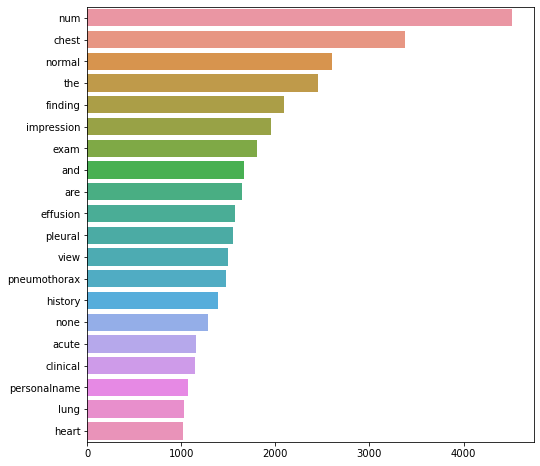

In [15]:
plot_ngram_counts(unigrams)

<AxesSubplot:>

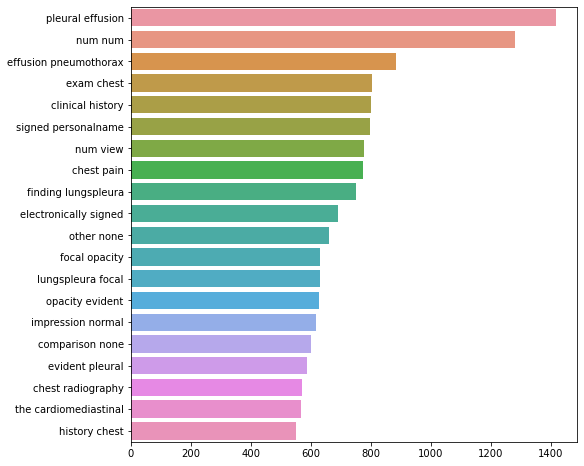

In [16]:
plot_ngram_counts(bigrams)

<AxesSubplot:>

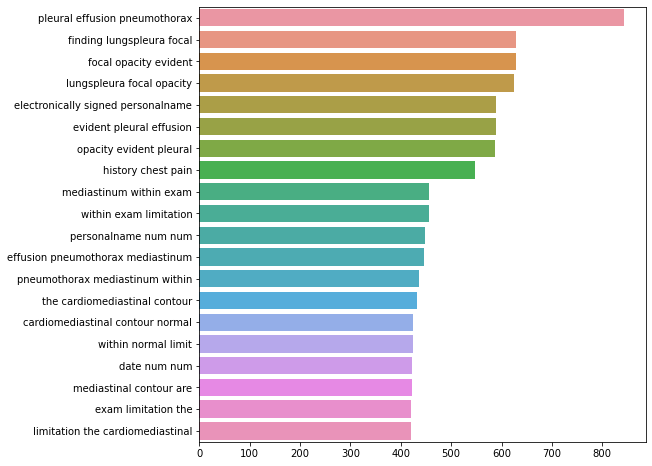

In [17]:
plot_ngram_counts(trigrams)

In [18]:
'''parameters for LDA visualization'''
dictionary = Dictionary(all_reports)
bag_of_words = [dictionary.doc2bow(report) for report in all_reports]
lda_model = LdaMulticore(bag_of_words, num_topics=4, id2word=dictionary, passes=10)

In [19]:
'''topics from LDA model'''
lda_model.show_topics()

[(0,
  '0.096*"chest" + 0.055*"dictated" + 0.050*"datetime" + 0.050*"pain" + 0.044*"history" + 0.043*"clinical" + 0.028*"normal" + 0.025*"num" + 0.022*"personalname" + 0.021*"negative"'),
 (1,
  '0.051*"the" + 0.047*"finding" + 0.045*"are" + 0.045*"normal" + 0.038*"pleural" + 0.037*"effusion" + 0.034*"pneumothorax" + 0.031*"and" + 0.026*"lung" + 0.024*"there"'),
 (2,
  '0.088*"num" + 0.070*"chest" + 0.051*"exam" + 0.046*"normal" + 0.039*"view" + 0.035*"history" + 0.033*"impression" + 0.032*"none" + 0.031*"clinical" + 0.026*"radiography"'),
 (3,
  '0.095*"num" + 0.041*"impression" + 0.039*"the" + 0.036*"chest" + 0.034*"personalname" + 0.030*"signed" + 0.027*"electronically" + 0.025*"acute" + 0.019*"view" + 0.018*"and"')]

In [20]:
'''LDA visualization'''
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bag_of_words, dictionary)
vis

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.010677 -0.122370       1        1  30.383981
1      0.200169 -0.001395       2        1  30.181571
2      0.002447  0.129712       3        1  27.290796
0     -0.213294 -0.005947       4        1  12.143652, topic_info=           Term         Freq        Total Category  logprob  loglift
6         chest  3355.000000  3355.000000  Default  30.0000  30.0000
23          num  4396.000000  4396.000000  Default  29.0000  29.0000
124    dictated   540.000000   540.000000  Default  28.0000  28.0000
7      clinical  1155.000000  1155.000000  Default  27.0000  27.0000
184    datetime   497.000000   497.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
8    comparison   117.549511   976.945831   Topic4  -4.3949  -0.0092
79        heart   106.289106  1011.048456   Topic4  -4.4956  -0.1442
27      pleural   114.499126  1562.023323   Topic4  -4.4212  -0.5048
14      finding   118.633387  2081.931147   Topic4  -4.3858  -0.7566
12     effusion   110.328917  1574.979140   Topic4  -4.4583  -0.5502

[292 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.317647  abnormality
0         2  0.310589  abnormality
0         3  0.065294  abnormality
0         4  0.307059  abnormality
273       1  0.972611        above
...     ...       ...          ...
40        4  0.003295       within
538       1  0.951813  workstation
293       1  0.963024    yesterday
293       2  0.025343    yesterday
589       3  0.794481         your

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [21]:
'''initialize vectorizer'''
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(list_of_reports)
X.shape

(3948, 912)

In [22]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [23]:
'''create dataframes for each field, for plotting'''
exam_tsne = pd.DataFrame(columns={'text', 'x', 'y'})
exam_tsne['text'] = list(report_df['exam'])
exam_tsne['x'] = X_tsne[:987][:, 0]
exam_tsne['y'] = X_tsne[:987][:, 1]

find_tsne = pd.DataFrame(columns={'text', 'x', 'y'})
find_tsne['text'] = list(report_df['findings'])
find_tsne['x'] = X_tsne[987:1974][:, 0]
find_tsne['y'] = X_tsne[987:1974][:, 1]

clin_tsne = pd.DataFrame(columns={'text', 'x', 'y'})
clin_tsne['text'] = list(report_df['clinicaldata'])
clin_tsne['x'] = X_tsne[1974:2961][:, 0]
clin_tsne['y'] = X_tsne[1974:2961][:, 1]

impr_tsne = pd.DataFrame(columns={'text', 'x', 'y'})
impr_tsne['text'] = list(report_df['impression'])
impr_tsne['x'] = X_tsne[2961:][:, 0]
impr_tsne['y'] = X_tsne[2961:][:, 1]

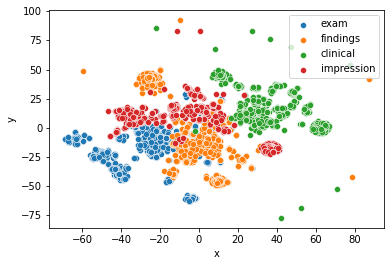

In [24]:
'''scatterplot of each fields tsne distribution'''
sns.scatterplot(x=exam_tsne['x'], y=exam_tsne['y'], label='exam')
sns.scatterplot(x=find_tsne['x'], y=find_tsne['y'], label='findings')
sns.scatterplot(x=clin_tsne['x'], y=clin_tsne['y'], label='clinical')
sns.scatterplot(x=impr_tsne['x'], y=impr_tsne['y'], label='impression')

plt.show()

In [25]:
'''initialize tdidf vectorizer'''
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(list_of_reports)

In [26]:
tfidf_tsne = TSNE(n_components=2, n_iter=500, learning_rate=100)
X_tfidf_tsne = tfidf_tsne.fit_transform(X_tfidf)

In [27]:
exam_tfidf = pd.DataFrame(columns={'text', 'x', 'y'})
exam_tfidf['text'] = list(report_df['exam'])
exam_tfidf['x'] = X_tfidf_tsne[:987][:, 0]
exam_tfidf['y'] = X_tfidf_tsne[:987][:, 1]

find_tfidf = pd.DataFrame(columns={'text', 'x', 'y'})
find_tfidf['text'] = list(report_df['findings'])
find_tfidf['x'] = X_tfidf_tsne[987:1974][:, 0]
find_tfidf['y'] = X_tfidf_tsne[987:1974][:, 1]

clin_tfidf = pd.DataFrame(columns={'text', 'x', 'y'})
clin_tfidf['text'] = list(report_df['clinicaldata'])
clin_tfidf['x'] = X_tfidf_tsne[1974:2961][:, 0]
clin_tfidf['y'] = X_tfidf_tsne[1974:2961][:, 1]

impr_tfidf = pd.DataFrame(columns={'text', 'x', 'y'})
impr_tfidf['text'] = list(report_df['impression'])
impr_tfidf['x'] = X_tfidf_tsne[2961:][:, 0]
impr_tfidf['y'] = X_tfidf_tsne[2961:][:, 1]

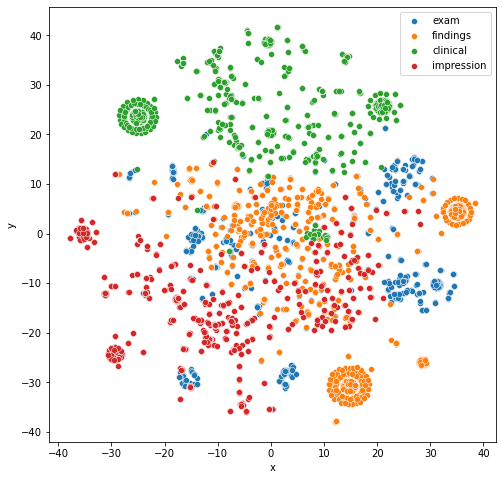

In [28]:
fig, scatter = plt.subplots(figsize=(8, 8))

sns.scatterplot(x=exam_tfidf['x'], y=exam_tfidf['y'], label='exam')
sns.scatterplot(x=find_tfidf['x'], y=find_tfidf['y'], label='findings')
sns.scatterplot(x=clin_tfidf['x'], y=clin_tfidf['y'], label='clinical')
sns.scatterplot(x=impr_tfidf['x'], y=impr_tfidf['y'], label='impression')

plt.show()

In [183]:
'''create X and y value of list of reports texts, text labels'''
exams = list(report_df['exam'].values)
exams = [report for report in exams if len(report) > 0]

findings = list(report_df['findings'].values)
findings = [report for report in findings if len(report) > 0]

clinicaldata = list(report_df['clinicaldata'].values)
clinicaldata = [report for report in clinicaldata if len(report) > 0]

impression = list(report_df['impression'].values)
impression = [report for report in impression if len(report) > 0]

texts = exams + findings + clinicaldata + impression
labels = ['exam'] * len(exams) + ['findings'] * len(findings) + ['clinicaldata'] * len(clinicaldata) + ['impression'] * len(impression) 

In [140]:
len(labels)

3944

In [181]:
tfidf_vectorizer = TfidfVectorizer()
X = list_of_reports
X = tfidf_vectorizer.fit_transform(X)
y = labels

In [184]:
'''split data into training and testing sets'''
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.20, 
                                                random_state=42, stratify=labels)

In [185]:
regression = LogisticRegression(multi_class='ovr', solver='liblinear')
regression.fit(X_train, y_train)
regression.score(X_test, y_test)

ValueError: could not convert string to float: 'clinical history chest pain'

array([[197,   0,   0,   0],
       [  0, 192,   3,   2],
       [  0,   1, 196,   0],
       [  0,   0,   1, 197]])

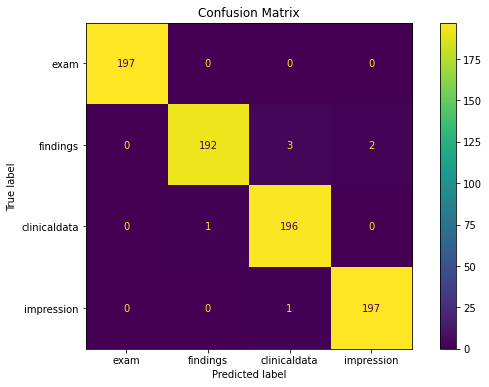

In [144]:
'''display confusion matrix'''
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Confusion Matrix")
display = plot_confusion_matrix(regression, X_test, y_test, 
                                display_labels=report_df.columns,
                                ax=ax)
display.confusion_matrix

In [145]:
'''word2vec implementation'''
X = texts
y = labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

label_mapping = {i: field for i, field in enumerate(encoder.classes_)}

3237

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=labels)

In [167]:
model = Word2Vec(sentences=X_train, vector_size=300, workers=2, min_count=3, window=5)

In [168]:
training = pd.DataFrame(columns=['text', 'label'])
training['text'] = X_train
training['label'] = y_train

testing = pd.DataFrame(columns=['text', 'label'])
testing['text'] = X_test
testing['label'] = y_test

In [169]:
len(training)

3352

In [170]:
def sentence_embedding(sentence):
    vectors = []
    for word in sentence:
        try:
            vector = model.wv.get_vector(word)
        except KeyError:
            vector = [0] * 300
        vectors.append(vector)
    vector = np.sum(vectors, axis=0)
    return vector / len(sentence)

In [171]:
training['text'] = training['text'].apply(lambda row: sentence_embedding(row))
logX_train = training['text'].values.tolist()
testing['text'] = testing['text'].apply(lambda row: sentence_embedding(row))
logX_test = testing['text'].values.tolist()

In [172]:
w2v_train

0       [0.009804454, 0.060894143, 0.012292604, 0.0809...
1       [-0.005228604, 0.02327403, 0.010907188, 0.0754...
2       [0.011954975, 0.066172265, 0.007710547, 0.0924...
3       [-0.00036786584, 0.07176963, 0.013782982, 0.07...
4       [0.009084433, 0.07925512, 0.017307399, 0.08069...
                              ...                        
3232    [0.024015138, 0.054815724, 0.015150526, 0.0819...
3233    [0.008540097, 0.0458583, 0.010420013, 0.074534...
3234    [-0.006942209, 0.068229645, -0.052453186, -0.0...
3235    [0.030847615, 0.05111093, 0.016412564, 0.07176...
3236    [-0.001982126, 0.08031196, 0.012026234, 0.0869...
Name: text, Length: 3237, dtype: object

In [173]:
regression = LogisticRegression(multi_class='ovr', solver="liblinear")
regression.fit(logX_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [174]:
y_pred = regression.predict(logX_test)

In [175]:
accuracy_score(y_pred, y_test)

0.768581081081081